In [2]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [3]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [8]:
# Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [4]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [5]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [6]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [ ]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

100%|██████████| 1/1 [00:00<00:00, 399.61it/s]


In [17]:
basins_problems2 = pd.read_csv(r"..\data\basins_problems_filter_2.csv")
basins_problems2

,basin
0,AT000080
1,AT000120
2,AT000159
3,AT000372
4,AT000373
...,...
369,SE000083
370,SE000103
371,SE000118
372,SI000029


In [18]:
Outliers = ["DEBB0050", 
"DK000087",
"ES000172",
"ES000478",
"ES001114",
"FI000202",
"FI000506",
"FR001271",
"FR001475",
"ITIS0107",
"NL000012",
"PT000211",
"PT000218",
"PT000263",
"DEHE0953",
"DEHE0970",
"DEHE0989",
"DEHE1008",
"DEHE1013",
"DEHE1014",
"DK000094"]

In [20]:
estreams_attributes_clipped_filters2 = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.index.isin(basins_problems2.basin)]

estreams_attributes_clipped_filters2

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR000183,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,5.440,0.000,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0
FR003252,A631101001,La Meurthe Ã Azerailles et Ã Baccarat,FR,FR_EAUFRANCE,La Meurthe à Azerailles et à Baccarat,6.738613,48.449237,6.738613,48.449237,260,...,6.226,0.004,0.007,9.0,59.0,0.0,41.0,56.0,17.0,27.0
FR003254,A643112001,La Vezouze Ã BlÃ¢mont et Ã FrÃ©monville,FR,FR_EAUFRANCE,La Vezouze à Blâmont et à Frémonville,6.843861,48.588049,6.843861,48.588049,265,...,5.071,0.000,0.001,4.0,64.0,36.0,0.0,63.0,37.0,0.0


In [ ]:
# Create a folder to save the plots
output_dir = r"..\results\plots"
os.makedirs(output_dir, exist_ok=True)

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    csv_file = fr"C:\Users\nascimth\Documents\data\EStreams\data\estreams_timeseries_{basin_id}.csv"
    
    df = pd.read_csv(csv_file)
    
    column_name = basin_id
    
    # Ensure the first column is treated as the Date index
    df.set_index(df.columns[0], inplace=True)
    df = df.loc["1988-10-01":"2015-09-30"]

    # Plotting
    plt.figure(figsize=(10, 4))
    df['q_mean'].plot(linewidth=0.5)
    plt.title(f"Basin: {basin_id}")
    plt.xlabel("Date")
    plt.ylabel("q_mean")
    #plt.tight_layout()

    # Save the plot
    output_path = os.path.join(output_dir, f"{basin_id}.png")
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid overlap in next iteration

100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


<Axes: >

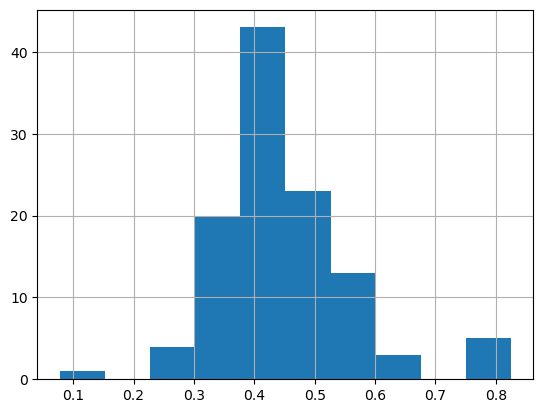

In [30]:
estreams_attributes_clipped_filters.q_runoff_ratio.hist()

In [32]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
FR000174,A812200001,A8122000,FR,FR_EAUFRANCE,L'Yron à Hannonville-Suzémont,5.837081,49.098776,5.837081,49.098776,197,...,2.131,0.070,0.040,2.0,0.0,100.0,0.0,1.0,99.0,0.0
FR003259,A664031002,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR,FR_EAUFRANCE,L'Arentèle à Saint-Gorgon et à Sainte-Hélène,6.645964,48.324169,6.645964,48.324169,295,...,3.622,0.011,0.009,2.0,66.0,34.0,0.0,35.0,65.0,0.0
FR003266,A712201001,L'Esch Ã Jezainville,FR,FR_EAUFRANCE,L'Esch à Jezainville,6.043284,48.866376,6.043284,48.866376,182,...,2.120,0.025,0.057,2.0,0.0,100.0,0.0,0.0,100.0,0.0


In [9]:
estreams_attributes_clipped_filters

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


In [33]:
import pandas as pd
import os
import tqdm

data_folder = r"C:\Users\nascimth\Documents\data\EStreams\data"
gantt_segments = []

for basin_id in tqdm.tqdm(estreams_attributes_clipped_filters.index):
    file_path = os.path.join(data_folder, f"estreams_timeseries_{basin_id}.csv")

    # Load CSV with datetime index
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data = data.loc["1988-10-01":"2015-09-30"]

    # Get availability mask
    valid = data["q_mean"].notna()

    # Identify change points in availability (True to False or vice-versa)
    change_points = valid.ne(valid.shift()).cumsum()

    # Group by continuous segments
    for grp, seg in data[valid].groupby(change_points):
        start = seg.index.min()
        end = seg.index.max()
        gantt_segments.append((basin_id, start, end))


100%|██████████| 112/112 [00:06<00:00, 17.92it/s]


In [ ]:
gantt_df = pd.DataFrame(gantt_segments, columns=["basin", "start", "end"])
gantt_df = gantt_df.sort_values(["basin", "start"]).reset_index(drop=True)

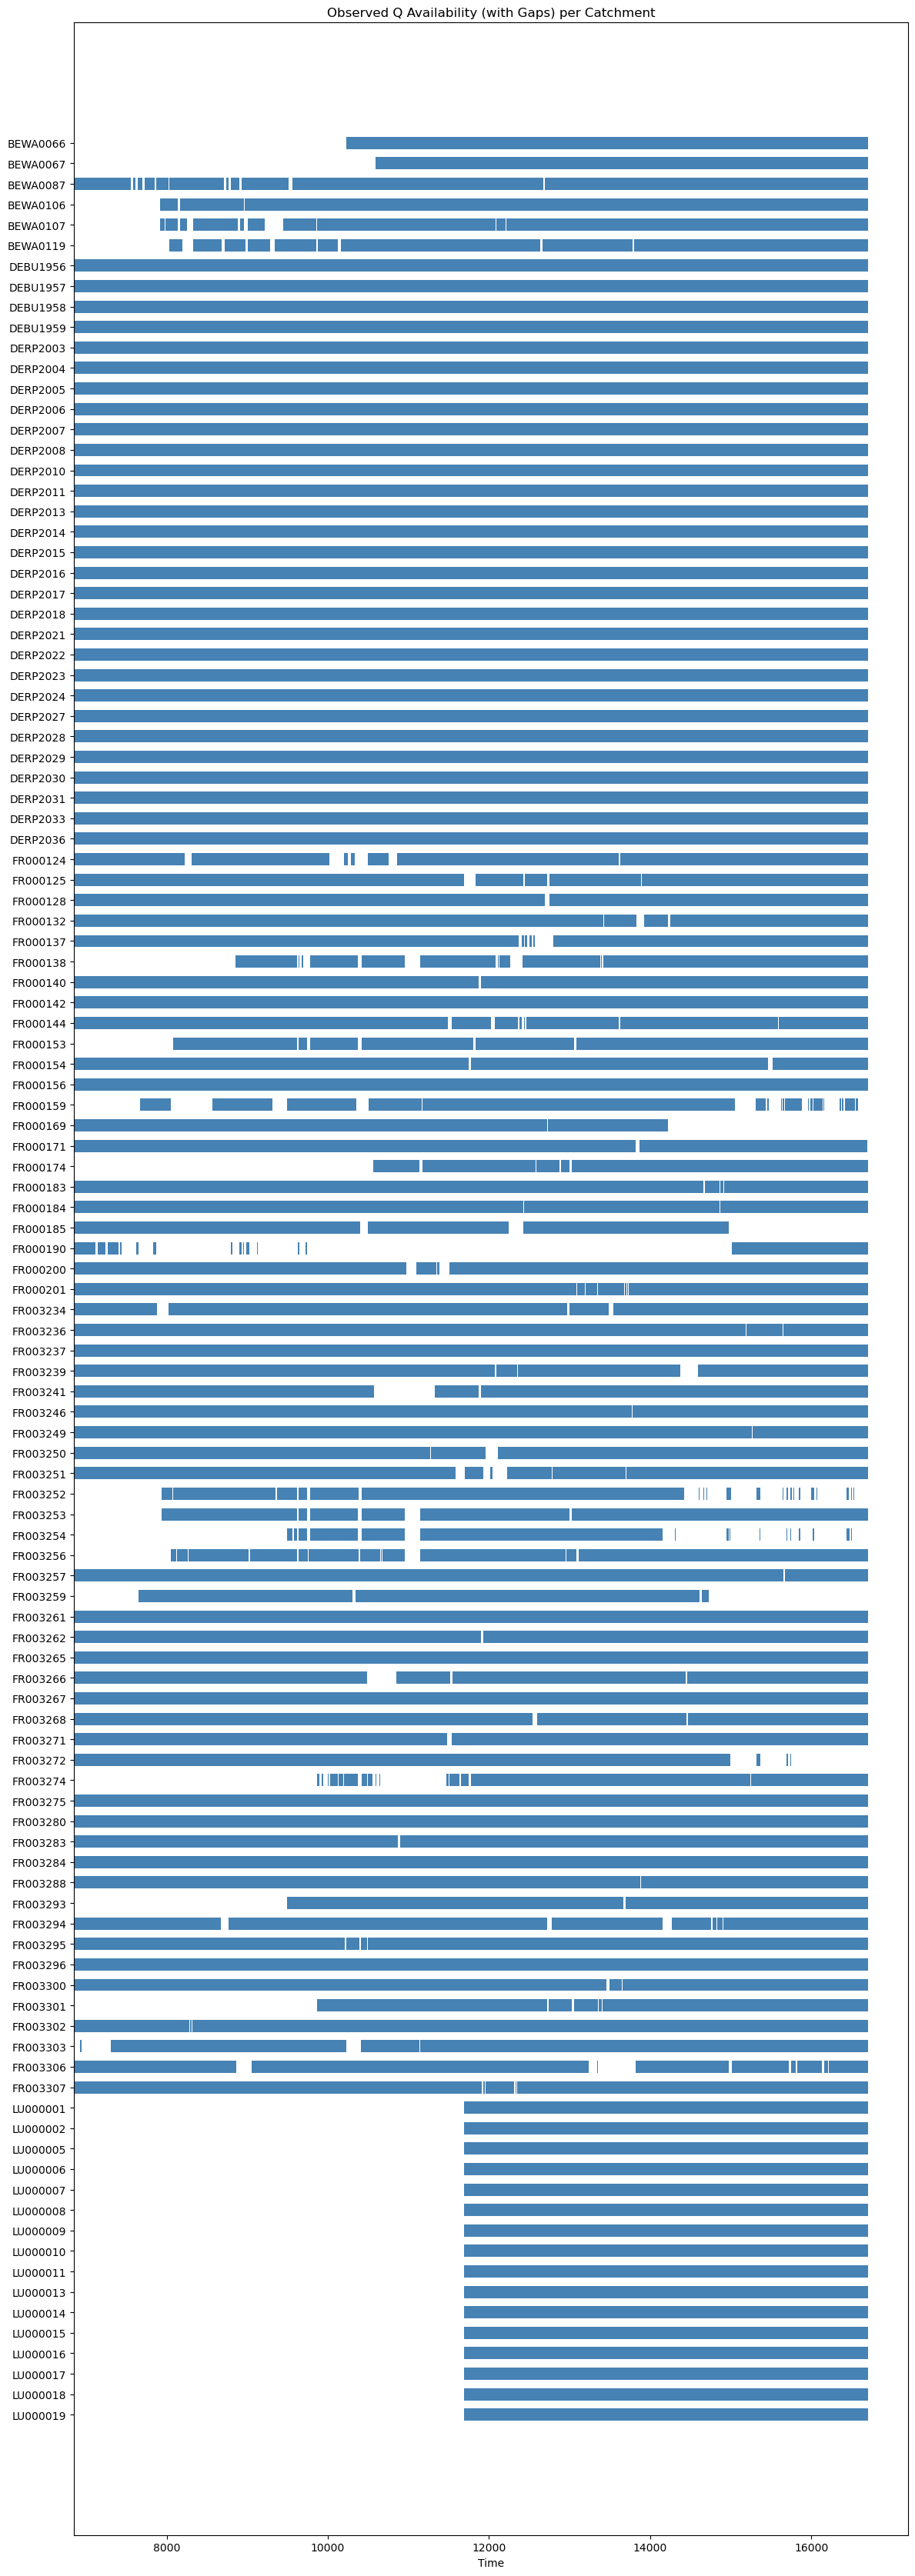

In [38]:
import matplotlib.pyplot as plt

# Assign a numeric index for plotting on y-axis
basin_to_y = {basin: i for i, basin in enumerate(gantt_df["basin"].unique())}
gantt_df["y"] = gantt_df["basin"].map(basin_to_y)

fig, ax = plt.subplots(figsize=(12, len(basin_to_y) * 0.3))

for _, row in gantt_df.iterrows():
    width = (row["end"] - row["start"]).days
    ax.barh(y=row["y"], left=row["start"], width=width, height=0.6, color="steelblue")

ax.set_yticks(list(basin_to_y.values()))
ax.set_yticklabels(list(basin_to_y.keys()))
ax.invert_yaxis()
ax.set_xlabel("Time")
ax.set_title("Observed Q Availability (with Gaps) per Catchment")
plt.tight_layout()
plt.show()


In [39]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3].q_runoff_ratio

basin_id
BEWA0087    0.078
FR000174    0.271
FR003259    0.295
FR003266    0.253
Name: q_runoff_ratio, dtype: float64

In [ ]:
# To be deleted:

# Too short time-series
FR000190, 

# Runoff ratio too small:
BEWA0087, 

# Problem in the time-series:
FR003303, FR003306, 

In [ ]:
# List of indexes to remove
to_remove = ['FR000190', 'BEWA0087', 'FR003303', 'FR003306']

# Drop them from the DataFrame
estreams_attributes_filtered = estreams_attributes_clipped_filters.drop(index=to_remove)

estreams_attributes_filtered

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,7.497,1.400,3.429,16.0,3.0,3.0,94.0,75.0,25.0,0.0
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,8.920,0.000,0.075,8.0,2.0,0.0,98.0,64.0,36.0,0.0
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,7.096,1.200,2.427,9.0,0.0,0.0,100.0,100.0,0.0,0.0
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,6.996,0.200,0.605,6.0,4.0,15.0,81.0,100.0,0.0,0.0
BEWA0119,63300000,Ouren,BE,BE_SPW,Our,6.141814,50.141935,6.141814,50.141935,NaN,...,7.381,1.400,3.429,17.0,3.0,3.0,94.0,75.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,5.680,0.045,0.045,25.0,2.0,0.0,98.0,100.0,0.0,0.0
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,2.863,0.004,0.009,15.0,14.0,86.0,0.0,0.0,100.0,0.0
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,4.753,1.641,4.770,78.0,19.0,31.0,50.0,41.0,59.0,0.0


In [43]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes_filtered.copy()

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

estreams_attributes_clipped_sorted.loc[:, ["area_estreams"]]

,area_estreams
basin_id,
DERP2028,50.000
DERP2006,54.000
BEWA0106,58.549
DERP2027,63.000
FR003234,64.468
...,...
FR003272,9391.476
FR003284,10801.232
DEBU1956,11500.000


In [76]:
import numpy as np
import pandas as pd

# Base dataframe
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

# Parameters
n_groups = 8
total_gauges = len(df_sorted)  # should be 108

# Separate LU and non-LU
lu_mask = df_sorted['basin_id'].str.contains("LU")
df_lu = df_sorted[lu_mask].copy()
df_nonlu = df_sorted[~lu_mask].copy()

assert len(df_lu) == 16, "You must have exactly 16 LU gauges."

# Shuffle LU and assign 2 per group
df_lu = df_lu.sample(frac=1, random_state=42).reset_index(drop=True)
grouped_gauges = {f'Group_{i+1}': [df_lu.iloc[2*i], df_lu.iloc[2*i + 1]] for i in range(n_groups)}

# Remaining slots: 14 for 4 groups, 13 for 4 groups → minus 2 LU = 12 and 11
remaining_slots = {f'Group_{i+1}': (14 if i < 4 else 13) - 2 for i in range(n_groups)}

# Step 1: Stratify non-LU gauges by area
df_nonlu_sorted = df_nonlu.sort_values(by='area_estreams').reset_index(drop=True)
n_strata = sum(remaining_slots.values())  # 92 total remaining
strata = np.array_split(df_nonlu_sorted, n_strata)

# Step 2: Assign each stratum to a group, round-robin style
np.random.seed(42)
group_cycle = list(grouped_gauges.keys()) * 20  # overfill to be safe
group_idx = 0

for stratum in strata:
    stratum_sampled = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    # Find next group with available slot
    while remaining_slots[group_cycle[group_idx]] == 0:
        group_idx += 1
    group_name = group_cycle[group_idx]
    grouped_gauges[group_name].append(stratum_sampled)
    remaining_slots[group_name] -= 1
    group_idx += 1

# Final assembly
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}

# Final validation
all_combined = pd.concat(groups_df.values())
print(f"✅ Total gauges assigned: {len(all_combined)} (should be 108)")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be 108)")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# Area summary
for k, df_group in groups_df.items():
    print(f"{k}: {len(df_group)} gauges, "
          f"{df_group['basin_id'].str.contains('LU').sum()} LU gauges, "
          f"mean area: {df_group['area_estreams'].mean():.1f}")


✅ Total gauges assigned: 108 (should be 108)
✅ Unique basin_ids: 108 (should be 108)
✅ Any duplicates? False
Group_1: 14 gauges, 2 LU gauges, mean area: 1227.5
Group_2: 14 gauges, 2 LU gauges, mean area: 1461.2
Group_3: 14 gauges, 2 LU gauges, mean area: 2315.0
Group_4: 14 gauges, 2 LU gauges, mean area: 2505.3
Group_5: 13 gauges, 2 LU gauges, mean area: 948.3
Group_6: 13 gauges, 2 LU gauges, mean area: 938.5
Group_7: 13 gauges, 2 LU gauges, mean area: 1036.2
Group_8: 13 gauges, 2 LU gauges, mean area: 1188.4


In [111]:
import numpy as np
import pandas as pd

# Set your number of groups
n_groups = 7

# Input DataFrame
df_sorted = estreams_attributes_clipped_sorted.copy().reset_index(drop=True)
df_sorted["basin_id"] = estreams_attributes_clipped_sorted.index

# Split LU and non-LU
df_lu = df_sorted[df_sorted['basin_id'].str.contains("LU")].copy()
df_nonlu = df_sorted[~df_sorted['basin_id'].str.contains("LU")].copy()

n_lu = len(df_lu)
print(f"ℹ️ Total LU gauges: {n_lu}")

# Shuffle LU gauges
df_lu = df_lu.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 1: Determine LU assignment per group
base_lu_per_group = n_lu // n_groups
extra_lu = n_lu % n_groups  # remainder to spread

# Create LU assignment list
lu_counts = [base_lu_per_group] * n_groups
for i in range(extra_lu):
    lu_counts[i] += 1  # Distribute extra LU gauges to first few groups

# Step 2: Assign LU gauges
grouped_gauges = {}
lu_index = 0
for i in range(n_groups):
    group_name = f'Group_{i+1}'
    n_lu_this_group = lu_counts[i]
    grouped_gauges[group_name] = df_lu.iloc[lu_index:lu_index + n_lu_this_group].to_dict('records')
    lu_index += n_lu_this_group

# Step 3: Assign non-LU gauges fairly and with area balance
df_nonlu_sorted = df_nonlu.sort_values(by='area_estreams').reset_index(drop=True)
total_nonlu = len(df_nonlu_sorted)

# Determine how many total gauges each group should get
total_gauges = len(df_sorted)
gauges_per_group = total_gauges // n_groups
extras = total_gauges % n_groups

# Track how many more non-LU gauges each group needs
remaining_slots = {}
for i in range(n_groups):
    group = f'Group_{i+1}'
    target_size = gauges_per_group + (1 if i < extras else 0)
    current_size = len(grouped_gauges[group])
    remaining_slots[group] = target_size - current_size

# Step 4: Stratify and assign non-LU gauges
n_slots = sum(remaining_slots.values())
strata = np.array_split(df_nonlu_sorted, n_slots)
np.random.seed(42)
group_cycle = list(remaining_slots.keys()) * 20
group_idx = 0

for stratum in strata:
    selected = stratum.sample(n=1, random_state=np.random.randint(10000)).iloc[0]
    # Find a group that still has space
    while remaining_slots[group_cycle[group_idx]] == 0:
        group_idx += 1
    group = group_cycle[group_idx]
    grouped_gauges[group].append(selected)
    remaining_slots[group] -= 1
    group_idx += 1

# Final groups
groups_df = {k: pd.DataFrame(v).reset_index(drop=True) for k, v in grouped_gauges.items()}
all_combined = pd.concat(groups_df.values())

# Final check
print(f"\n✅ Total gauges assigned: {len(all_combined)} (should be {len(df_sorted)})")
print(f"✅ Unique basin_ids: {all_combined['basin_id'].nunique()} (should be {len(df_sorted)})")
print(f"✅ Any duplicates? {all_combined['basin_id'].duplicated().any()}")

# LU per group
for k, g in groups_df.items():
    n_lu = g['basin_id'].str.contains("LU").sum()
    print(f"{k}: {len(g)} gauges | LU: {n_lu} | Mean area: {g['area_estreams'].mean():.1f}")


ℹ️ Total LU gauges: 16

✅ Total gauges assigned: 108 (should be 108)
✅ Unique basin_ids: 108 (should be 108)
✅ Any duplicates? False
Group_1: 16 gauges | LU: 3 | Mean area: 566.2
Group_2: 16 gauges | LU: 3 | Mean area: 1014.5
Group_3: 16 gauges | LU: 2 | Mean area: 2561.5
Group_4: 15 gauges | LU: 2 | Mean area: 1375.3
Group_5: 15 gauges | LU: 2 | Mean area: 1238.3
Group_6: 15 gauges | LU: 2 | Mean area: 1365.3
Group_7: 15 gauges | LU: 2 | Mean area: 2174.5


In [112]:
groups_df["Group_1"]["basin_id"]

0     LU000018
1     LU000010
2     LU000001
3     DERP2028
4     FR000183
5     DERP2008
6     FR000137
7     FR003294
8     FR000185
9     FR000154
10    FR003307
11    FR003256
12    DERP2004
13    FR003252
14    FR003302
15    FR003249
Name: basin_id, dtype: object

In [132]:
groups_df["Group_7"][["basin_id", "area_estreams", 'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi']].sort_values("area_estreams")

,basin_id,area_estreams,perm_high_regi,perm_medium_regi,perm_low_regi
2,FR003250,67.143,4.0,0.0,96.0
3,FR000132,95.647,45.0,0.0,55.0
4,FR003254,112.818,64.0,36.0,0.0
5,DERP2010,137.000,25.0,47.0,28.0
6,FR000201,185.901,6.0,94.0,0.0
7,FR003300,278.241,42.0,58.0,0.0
0,LU000002,291.757,20.0,59.0,21.0
8,FR003267,363.099,0.0,100.0,0.0
1,LU000016,387.289,14.0,86.0,0.0
9,DERP2014,430.000,70.0,30.0,0.0


In [ ]:
catchments_ids = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

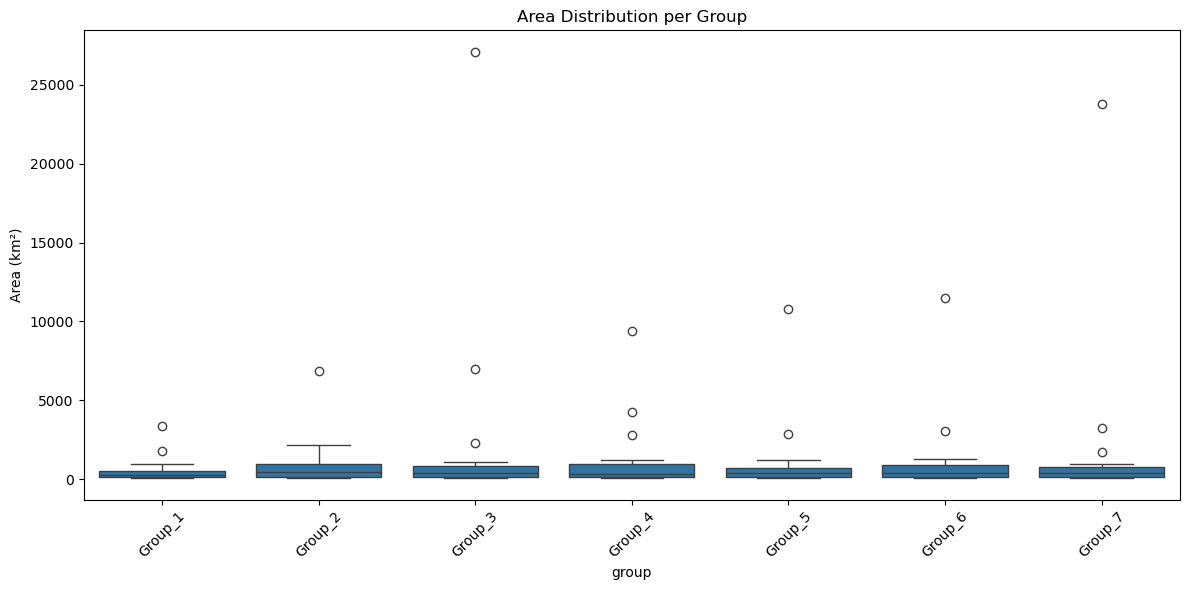

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([
    g.assign(group=group_name) for group_name, g in groups_df.items()
])

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='group', y='area_estreams')
plt.title("Area Distribution per Group")
plt.ylabel("Area (km²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Combine all groups into one DataFrame
combined_df = pd.concat(
    [df.assign(group=group_name) for group_name, df in groups_df.items()],
    ignore_index=True
)

len(combined_df.basin_id.unique())

108

In [124]:
combined_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,basin_id,group
0,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,NaN,...,0.015,17.0,39.0,61.0,0.0,0.0,100.0,0.0,LU000018,Group_1
1,6,Hunnebuer,LU,LU_CONTACTFORM,Eisch,6.079524,49.729184,6.079524,49.729184,NaN,...,0.026,16.0,42.0,58.0,0.0,1.0,99.0,0.0,LU000010,Group_1
2,17,Bigonville,LU,LU_CONTACTFORM,Sure,5.801399,49.869821,5.801399,49.869821,NaN,...,0.000,9.0,1.0,0.0,99.0,100.0,0.0,0.0,LU000001,Group_1
3,2674030900,Eisenschmitt,DE,DE_RP,Salm,6.718000,50.048000,6.718000,50.048000,NaN,...,0.000,10.0,80.0,7.0,13.0,79.0,20.0,1.0,DERP2028,Group_1
4,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0,FR000183,Group_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2628050400,Pruemzurlay,DE,DE_RP,Pruem,6.437000,49.868000,6.437000,49.868000,NaN,...,0.596,21.0,16.0,19.0,65.0,7.0,93.0,0.0,DERP2007,Group_7
104,A782101001,La Seille Ã Nomeny,FR,FR_EAUFRANCE,La Seille à Nomeny,6.227788,48.888271,6.227788,48.888271,181,...,0.436,5.0,8.0,92.0,0.0,0.0,100.0,0.0,FR003271,Group_7
105,A930108040,La Sarre Ã Wittring,FR,FR_EAUFRANCE,La Sarre à Wittring,7.150066,49.053225,7.150066,49.053225,200,...,2.205,16.0,17.0,83.0,0.0,15.0,85.0,0.0,FR003301,Group_7
106,2620050500,Bollendorf,DE,DE_RP,Sauer,6.359000,49.851000,6.359000,49.851000,NaN,...,4.160,65.0,17.0,30.0,53.0,50.0,50.0,0.0,DERP2003,Group_7


# End